# k-Armed Bandit Algorithms

In this notebook, you will implement some of the k-Armed Bandit algorithms described in [Sutton and Barto's book, Introduction to Reinforcement Learning](http://incompleteideas.net/book/the-book-2nd.html). A class ```kArmedBandit``` that  can represent k-armed bandit problems and the uniform k-armed bandit algorithm are already implemented. See the code for those and examples below, and add your implementation of other algorithms at the end of the notebook.

### Install dependendices

In [81]:
! pip install numpy matplotlib

### Imports

In [82]:
import matplotlib.pyplot as plt
import numpy as np

# Setting the random seed allows for replication of results of experiments that
# rely on np.random:
np.random.seed(1234)

### The ```kArmedBandit``` class

An instance of a ```kArmedBandit``` class represents one instance of a k-armed bandit problem. A problem is represented by $k$ arms where each arm is defined by the mean and variance of its payout. Each instance of the class keeps track of mean reward, history of plays, how many times each arm has been played and so forth.

The histories (of plays, rewards, and mean rewards) grow by one item each time a new play is made.

In [83]:
class kArmedBandit:
  """
  Represent an instance of a k-armed bandit problem
  """
  def __init__(self, means, variances):
    """
    Create an instance with means and variances for the bandit's arms.
    """
    assert len(means) == len(variances), f"Length of means ({len(means)}) and variances ({len(variances)}) must match"

    self.true_means = means
    self.true_variances = variances
    self.number_of_arms = len(means)

    # History of rewards received, one added each time an arm is played
    self.history_of_rewards = []
    # History of mean rewards received, one added each time an arm is played
    self.history_of_mean_rewards = []
    # History of arms played, one added each time an arm is played
    self.history_of_plays = []
    # Number of times each arm has been played
    self.number_of_plays = np.zeros(self.number_of_arms)
    # Accumulated reward for each arm
    self.accumulated_observed_rewards = np.zeros(self.number_of_arms)
    # Total reward observed
    self.total_reward = 0
    self.total_plays = 0

  def play(self, arm_number):
    """
    Play a given arm and return the payout/reward
    """

    # Sample reward from the arm's normal distribution
    reward = np.random.normal(self.true_means[arm_number], self.true_variances[arm_number])

    # House keeping: record reward and current play in the lists and vars
    # necessary for plotting and making the implementation of algorithms easier
    self.history_of_rewards.append(reward)
    self.accumulated_observed_rewards[arm_number] += reward
    self.number_of_plays[arm_number] += 1
    self.history_of_plays.append(arm_number)
    self.total_reward += reward
    self.total_plays += 1
    self.history_of_mean_rewards.append(self.total_reward/(self.total_plays))

    return reward

  @property
  def observed_means(self):
    """
    Mean of observed rewards for each arm
    """
    # Convert lists to numpy arrays for element-wise operations
    accumulated_observed_rewards = np.array(self.accumulated_observed_rewards)
    number_of_plays = np.array(self.number_of_plays)

    # Replace zeros with ones in number_of_plays to avoid division by zero
    number_of_plays_with_no_zeros = np.where(number_of_plays == 0, 1, number_of_plays)

    # Element-wise division
    return accumulated_observed_rewards / number_of_plays_with_no_zeros

  @property
  def history_of_ideal_mean_rewards(self):
    """
    Get a history of ideal mean reward, that is, if the arm with the highest mean
    had always been played (useful when plotting results)
    """
    ideal = np.empty(self.total_plays)
    ideal.fill(np.max(self.true_means))
    return ideal

  def __len__(self):
    """
    Let the length of a k-armed bandit be k:
    """
    return self.number_of_arms

  def __str__(self):
    return "{self.number_of_arms} arms with true means: {self.true_means}, variances: {self.true_variances}".format(self=self)

  def generate_instance(number_of_arms, mean_low_limit, mean_high_limit, variance):
    """
    Class method for generating the means and variances for an instance.
    """
    means = np.random.rand(number_of_arms) * \
            (mean_high_limit - mean_low_limit) + mean_low_limit
    variances = np.empty(number_of_arms)
    variances.fill(variance)
    return (means, variances)



### Uniform bandit algorithm

The uniform bandit algorithm is simple: try each arm $w$ times and play the arm that yieded the highest mean payout for the rest the episodes.

In [84]:
class UniformBanditAlgorithm:
  def __init__(self, k_armed_bandit, w):
    """ Setup the algorithm """
    self.k_armed_bandit = k_armed_bandit
    self.w = w
    self.best_arm = None
    # Calculate how many episodes will be used for exploration in the beginning
    self.exploration_episodes = self.w * len(self.k_armed_bandit)

  def run(self, episodes):
    """ Run the algorithm for a given number of episodes """
    assert self.best_arm == None, "You should not call run() twice on the same instance, instead create a new instance"
    assert self.k_armed_bandit.total_plays == 0, "You should run an algorithm on the same instance twice, instead create a new instance"
    assert self.exploration_episodes <= episodes, "Not enough episodes to try all bandits {self.w} times".format(self=self)

    # Play each arm w times
    for arm in range(0, len(self.k_armed_bandit)):
      for i in range(0, self.w):
        self.k_armed_bandit.play(arm)

    # Find the index of the arm that yielded the highest mean payout
    self.best_arm = np.argmax(self.k_armed_bandit.observed_means)

    # Play the best arm for the rest of the episodes
    for _ in range(self.w * len(self.k_armed_bandit), episodes):
      self.k_armed_bandit.play(self.best_arm)

### Test of the uniform bandit algorithm on one instance



In [85]:
# Generate an instance with 10 arms, means from [-1,1] and a variance of 1
means, variances = kArmedBandit.generate_instance(10, -1, 1, 1)
problem_instance = kArmedBandit(means, variances)

print(problem_instance)

10 arms with true means: [-0.6169611   0.24421754 -0.12454452  0.57071717  0.55995162 -0.45481479
 -0.44707149  0.60374436  0.91627871  0.75186527], variances: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [86]:
# Create a uniform bandit algorithm for the problem instance with w=20
uniform_bandit = UniformBanditAlgorithm(problem_instance, 20)

# Run the algorithm for 1000 episodes
uniform_bandit.run(1000)

# Check if the algorithm found the best arm
print(f"Estimated best arm: {uniform_bandit.best_arm}, " \
      f"true best arm {np.argmax(problem_instance.true_means)}")

Estimated best arm: 8, true best arm 8


Note that the algorithm may not always find the best instance if, for instance, two means are close to one another or $w$ is too low.

### A plot of the results

[]

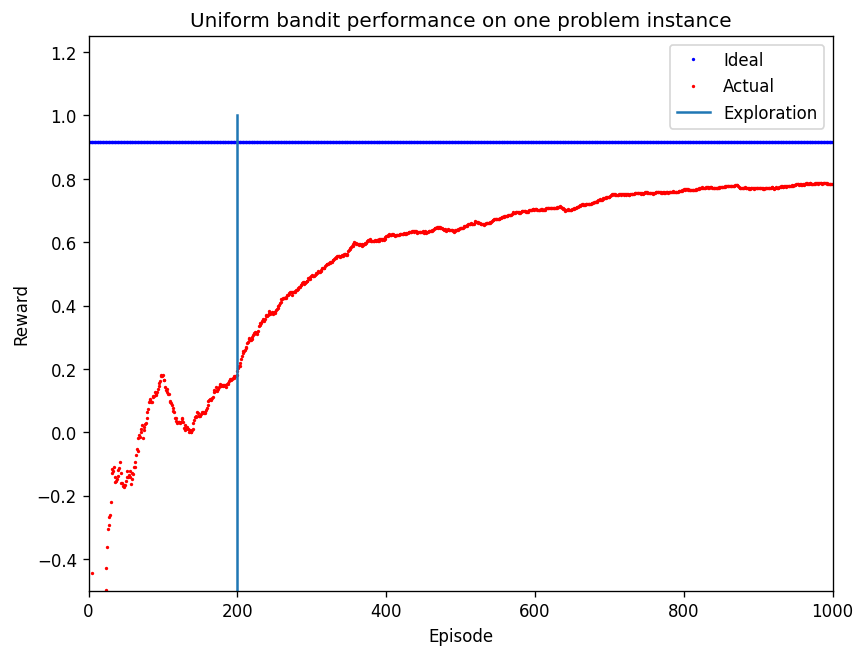

In [87]:
# Plot the results:
fig = plt.figure(figsize=(8, 6), dpi=120)
ax = fig.add_subplot(1, 1, 1)
plt.ylim(-0.5, 1.25)
plt.xlim(0, problem_instance.total_plays)

# Plot the ideal scenario when only the best arm is played vs. the actual:
p1 = ax.plot(problem_instance.history_of_ideal_mean_rewards, 'bo', markersize=1)
p2 = ax.plot(problem_instance.history_of_mean_rewards, 'ro', markersize=1)

# Plot a vertical line to indicate the cut-off between exploration
# and exploitation
ax.plot([uniform_bandit.exploration_episodes,
         uniform_bandit.exploration_episodes], [-0.5, 1])

plt.xlabel('Episode')
plt.ylabel('Reward')
plt.legend(["Ideal", "Actual", "Exploration"])

plt.title("Uniform bandit performance on one problem instance")

plt.plot()

### Uniform bandit on multiple instances

To approximate the general performance of an algorithm, it is often necessary to run it on multiple problem instances. The code below runs the uniform bandit algorithm on ```instances = 100```instances and plots the results.

In [88]:
# Config:
instances = 100
arms = 10
episodes = 1000
w = 20
np.random.seed(1234)

# Accumulate results across instances data for plotting:
accumulated_history_of_mean_rewards = np.zeros(episodes)
accumulated_history_of_ideal_mean_rewards = np.zeros(episodes)

uniform_bandit = None
times_best_arm_found = 0

# Create and run instances:
for i in range(0, instances):
  means, variances = kArmedBandit.generate_instance(arms, -1, 1, 1)
  instance = kArmedBandit(means, variances)
  uniform_bandit = UniformBanditAlgorithm(instance, w)
  uniform_bandit.run(episodes)

  accumulated_history_of_ideal_mean_rewards = accumulated_history_of_ideal_mean_rewards + instance.history_of_ideal_mean_rewards
  accumulated_history_of_mean_rewards = accumulated_history_of_mean_rewards + instance.history_of_mean_rewards

  if uniform_bandit.best_arm == np.argmax(instance.true_means):
    times_best_arm_found += 1

print(f"Times best arm found {times_best_arm_found}/{instances}")

Times best arm found 58/100


[]

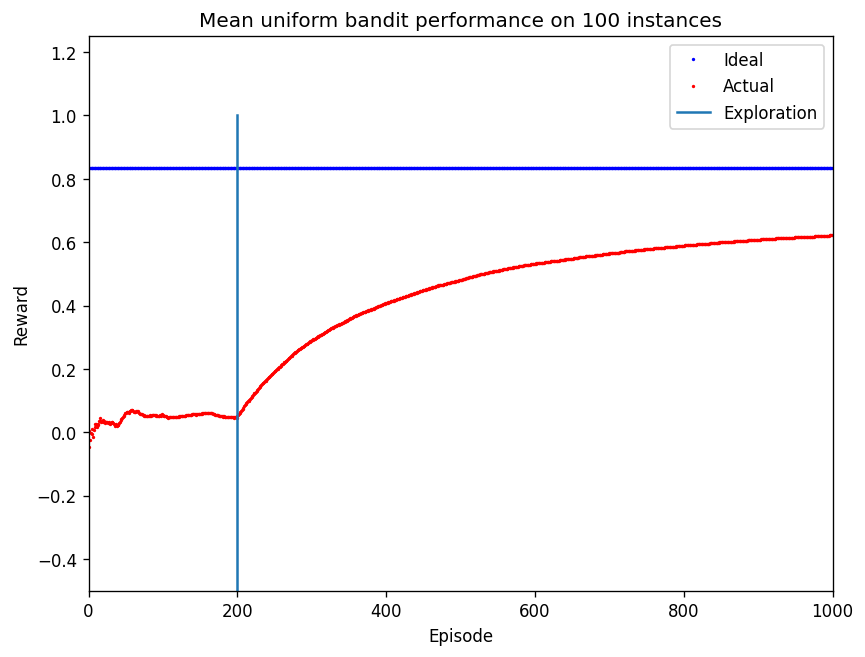

In [89]:
# Plot the results:
fig = plt.figure(figsize=(8, 6), dpi=120)
ax = fig.add_subplot(1, 1, 1)
plt.ylim(-0.5, 1.25)
plt.xlim(0, instance.total_plays)

# Plot the ideal scenario when only the best arm is played vs. the actual:
p1 = ax.plot(accumulated_history_of_ideal_mean_rewards / instances, 'bo', markersize=1)
p2 = ax.plot(accumulated_history_of_mean_rewards / instances, 'ro', markersize=1)

# Plot a vertical line to indicate the cut off between exploration and exploitation
ax.plot([uniform_bandit.exploration_episodes, uniform_bandit.exploration_episodes], [-0.5, 1])

plt.xlabel('Episode')
plt.ylabel('Reward')
plt.legend(["Ideal", "Actual", "Exploration"])

plt.title(f"Mean uniform bandit performance on {instances} instances")

plt.plot()

### Exercise: Implement, test and compare the $\epsilon$-Greedy action selection

Implement $\epsilon$-Greedy action selection below.

In [90]:
class EpsilonGreedyAlgorithm:
  def __init__(self, k_armed_bandit, epsilon):
    self.epsilon = epsilon
    self.k_armed_bandit = k_armed_bandit
    self.best_arm = None

  def run(self, episodes):
    assert self.best_arm == None, "You should not call run() twice on the same instance, instead create a new instance"
    assert self.k_armed_bandit.total_plays == 0, "You should run an algorithm on the same instance twice, instead create a new instance"
    
    for _ in range(episodes):
      if np.random.rand() < self.epsilon:
        # Explore: play a random arm
        arm_to_play = np.random.randint(0, len(self.k_armed_bandit))
      else:
        # Exploit: play the best arm so far
        arm_to_play = np.argmax(self.k_armed_bandit.observed_means)
      
      self.k_armed_bandit.play(arm_to_play)

    self.best_arm = np.argmax(self.k_armed_bandit.observed_means)

    

Test your implementation, first on one instance and then on multiple instances

In [91]:
# Generate an instance with 10 arms, means from [-1,1] and a variance of 1
means, variances = kArmedBandit.generate_instance(10, -1, 1, 1)
problem_instance = kArmedBandit(means, variances)

print(problem_instance)

# Create a uniform bandit algorithm for the problem instance with w=20
e_greedy_bandit = EpsilonGreedyAlgorithm(problem_instance, 0.05)

# Run the algorithm for 1000 episodes
e_greedy_bandit.run(1000)

# Check if the algorithm found the best arm
print(f"Estimated best arm: {e_greedy_bandit.best_arm}, " \
      f"true best arm {np.argmax(problem_instance.true_means)}")

10 arms with true means: [-0.26746338  0.24624063  0.62654785 -0.75873217 -0.75172002 -0.68900163
 -0.73696876  0.78037305 -0.42361083 -0.51257089], variances: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Estimated best arm: 7, true best arm 7


[]

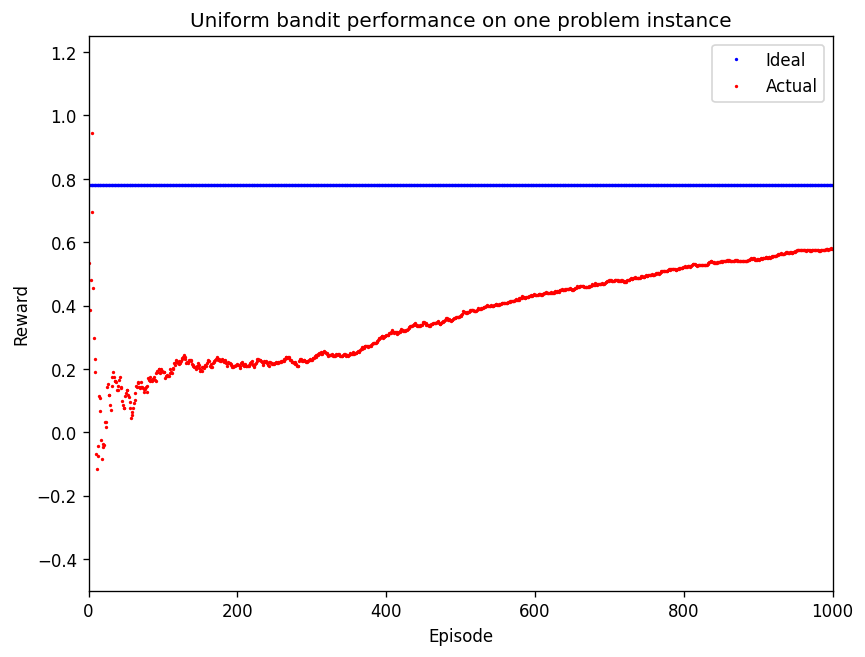

In [92]:
# Plot the results:
fig = plt.figure(figsize=(8, 6), dpi=120)
ax = fig.add_subplot(1, 1, 1)
plt.ylim(-0.5, 1.25)
plt.xlim(0, problem_instance.total_plays)

# Plot the ideal scenario when only the best arm is played vs. the actual:
p1 = ax.plot(problem_instance.history_of_ideal_mean_rewards, 'bo', markersize=1)
p2 = ax.plot(problem_instance.history_of_mean_rewards, 'ro', markersize=1)



plt.xlabel('Episode')
plt.ylabel('Reward')
plt.legend(["Ideal", "Actual"])

plt.title("Uniform bandit performance on one problem instance")

plt.plot()

In [93]:
# Config:
instances = 100
arms = 10
episodes = 1000
epsilon = 0.01
np.random.seed(1234)

# Accumulate results across instances data for plotting:
accumulated_history_of_mean_rewards_e = np.zeros(episodes)
accumulated_history_of_ideal_mean_rewards_e = np.zeros(episodes)

e_greedy_bandit = None
times_best_arm_found_e = 0

# Create and run instances:
for i in range(0, instances):
  means, variances = kArmedBandit.generate_instance(arms, -1, 1, 1)
  instance_e = kArmedBandit(means, variances)
  e_greedy_bandit = EpsilonGreedyAlgorithm(instance_e, epsilon)
  e_greedy_bandit.run(episodes)

  accumulated_history_of_ideal_mean_rewards_e = accumulated_history_of_ideal_mean_rewards_e + instance_e.history_of_ideal_mean_rewards
  accumulated_history_of_mean_rewards_e = accumulated_history_of_mean_rewards_e + instance_e.history_of_mean_rewards

  if e_greedy_bandit.best_arm == np.argmax(instance_e.true_means):
    times_best_arm_found_e += 1

print(f"Times best arm found {times_best_arm_found_e}/{instances}")
print(f"Final reward {accumulated_history_of_mean_rewards_e[-1]/100}")

Times best arm found 46/100
Final reward 0.6217589505929442


[]

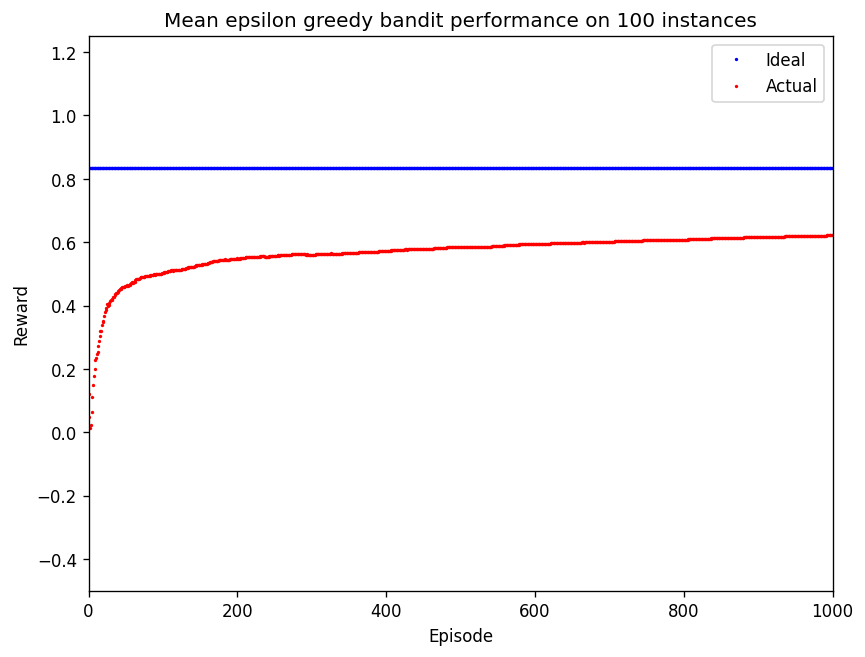

In [94]:
# Plot the results:
fig = plt.figure(figsize=(8, 6), dpi=120)
ax = fig.add_subplot(1, 1, 1)
plt.ylim(-0.5, 1.25)
plt.xlim(0, instance_e.total_plays)

# Plot the ideal scenario when only the best arm is played vs. the actual:
p1 = ax.plot(accumulated_history_of_ideal_mean_rewards_e / instances, 'bo', markersize=1)
p2 = ax.plot(accumulated_history_of_mean_rewards_e / instances, 'ro', markersize=1)

plt.xlabel('Episode')
plt.ylabel('Reward')
plt.legend(["Ideal", "Actual"])

plt.title(f"Mean epsilon greedy bandit performance on {instances} instances")

plt.plot()

Try to compare the performance of your $\epsilon$-greedy implementation with the uniform bandit algorithm
  

[]

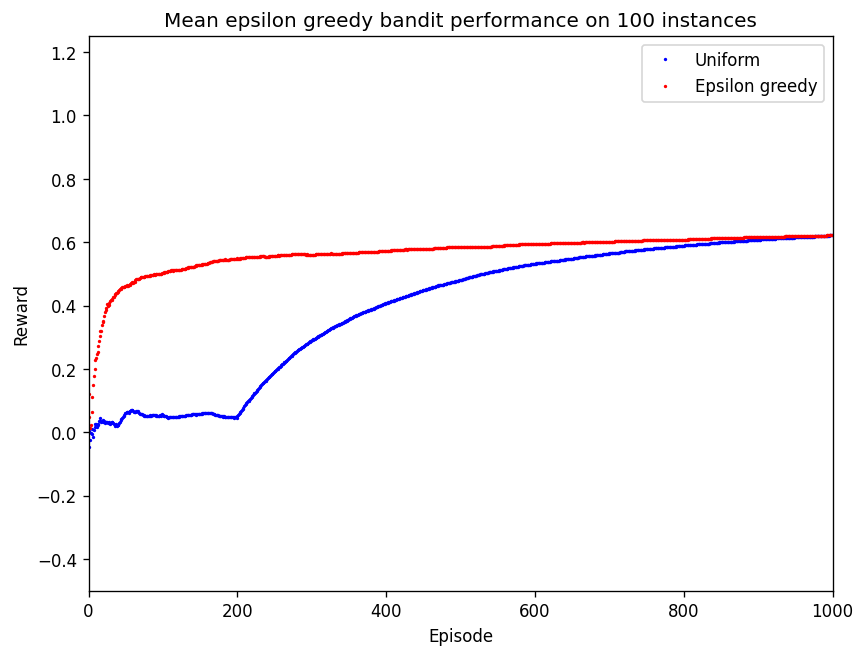

In [95]:
# Plot the results:
fig = plt.figure(figsize=(8, 6), dpi=120)
ax = fig.add_subplot(1, 1, 1)
plt.ylim(-0.5, 1.25)
plt.xlim(0, instance_e.total_plays)

# Plot the ideal scenario when only the best arm is played vs. the actual:
p1 = ax.plot(accumulated_history_of_mean_rewards / instances, 'bo', markersize=1)
p2 = ax.plot(accumulated_history_of_mean_rewards_e / instances, 'ro', markersize=1)

plt.xlabel('Episode')
plt.ylabel('Reward')
plt.legend(["Uniform", "Epsilon greedy"])

plt.title(f"Mean epsilon greedy bandit performance on {instances} instances")

plt.plot()

Jeg ikke helt sikker på hvor fair den her sammenligning er for det jo to forskellige instanser. Da man ikke kan bruge den samme flere gange med den givne kode
-- Det jo over 100 instancer af hver så det gucci, dit fjols!

### Exercise: Implement, test and compare the Upper Confidence Bound (UCB) algorithm


In [96]:
# Implement, test and compare an upper confidence bound algorithm with the
# other algorithms implemented in this notebook
class UpperConfidenceBound:
    def __init__(self, k_armed_bandit, c):
        self.c = c
        self.k_armed_bandit = k_armed_bandit
        self.best_estimate = np.zeros(len(k_armed_bandit))
        self.best_arm = None
        self.last_arm = 0
        self.arm_change = 0


    def run(self, episodes):
        assert self.best_arm == None, "You should not call run() twice on the same instance, instead create a new instance"
        assert self.k_armed_bandit.total_plays == 0, "You should run an algorithm on the same instance twice, instead create a new instance"
        upperConfidenceBound = np.zeros(len(self.k_armed_bandit))
        for i in range(episodes):
            for j in range(len(self.k_armed_bandit)):
                upperConfidenceBound[j]=self.best_estimate[j]+self.c*np.sqrt(np.log(self.k_armed_bandit.total_plays+1)/(self.k_armed_bandit.number_of_plays[j]+1))
            arm = np.argmax(upperConfidenceBound)

            # Tjek hvornår den skifter arm for at kunne se hvor meget den udforsker
            if arm != self.last_arm:
                self.arm_change += 1
                self.last_arm = arm
            reward = self.k_armed_bandit.play(arm)
            self.best_estimate[arm] = self.best_estimate[arm] + (1/self.k_armed_bandit.number_of_plays[arm])*(reward-self.best_estimate[arm])

        self.best_arm = np.argmax(self.k_armed_bandit.observed_means)

        
# class UpperConfidenceBound:
#     def __init__(self, k_armed_bandit, c):
#         self.c = c
#         self.k_armed_bandit = k_armed_bandit
#         self.action_estimates = np.zeros(len(k_armed_bandit))
#         self.best_arm = None

#     def run(self, episodes):
#         assert self.best_arm == None, "You should not call run() twice on the same instance, instead create a new instance"
#         assert self.k_armed_bandit.total_plays == 0, "You should run an algorithm on the same instance twice, instead create a new instance"
#         upper_bound_action_estimates = np.zeros(len(self.k_armed_bandit))
        
#         for i in range(episodes):
#             for j in range(len(self.k_armed_bandit)):
#                 upper_bound_action_estimates[j]= (self.action_estimates[j] +
#                     self.c * np.sqrt(np.log(self.k_armed_bandit.total_plays+1) / (self.k_armed_bandit.number_of_plays[j]+1)))
            
#             action = np.argmax(upper_bound_action_estimates)
            
#             reward = self.k_armed_bandit.play(action)
#             self.action_estimates[action] = self.action_estimates[action] + (1/self.k_armed_bandit.number_of_plays[action])*(reward-self.action_estimates[action])

#         self.best_arm = np.argmax(self.k_armed_bandit.observed_means)

10 arms with true means: [ 0.54322637  0.87169146 -0.20024394  0.10645823  0.92451878  0.0897227
 -0.48108663  0.9205195   0.44814887 -0.79850708], variances: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Estimated best arm: 4, true best arm 4
Explore count: 230 of 1000 episodes


[]

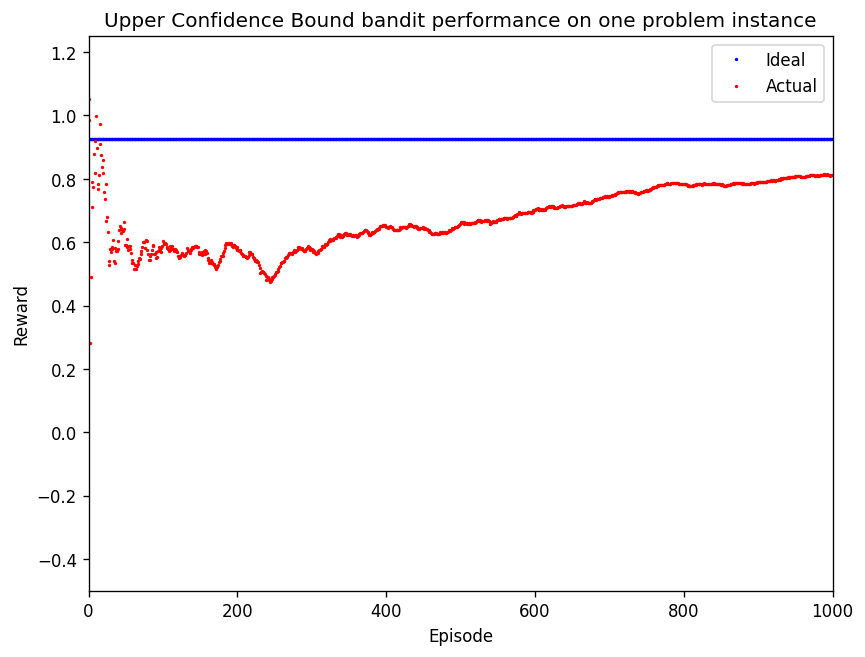

In [97]:
# Generate an instance with 10 arms, means from [-1,1] and a variance of 1
means, variances = kArmedBandit.generate_instance(10, -1, 1, 1)
problem_instance = kArmedBandit(means, variances)

print(problem_instance)

# Create a uniform bandit algorithm for the problem instance with w=20
ucb_bandit = UpperConfidenceBound(problem_instance, 2)

# Run the algorithm for 1000 episodes
ucb_bandit.run(1000)

# Check if the algorithm found the best arm
print(f"Estimated best arm: {ucb_bandit.best_arm}, " \
      f"true best arm {np.argmax(problem_instance.true_means)}")
print(f"Explore count: {ucb_bandit.arm_change} of 1000 episodes")

# Plot the results:
fig = plt.figure(figsize=(8, 6), dpi=120)
ax = fig.add_subplot(1, 1, 1)
plt.ylim(-0.5, 1.25)
plt.xlim(0, problem_instance.total_plays)

# Plot the ideal scenario when only the best arm is played vs. the actual:
p1 = ax.plot(problem_instance.history_of_ideal_mean_rewards, 'bo', markersize=1)
p2 = ax.plot(problem_instance.history_of_mean_rewards, 'ro', markersize=1)



plt.xlabel('Episode')
plt.ylabel('Reward')
plt.legend(["Ideal", "Actual"])

plt.title("Upper Confidence Bound bandit performance on one problem instance")

plt.plot()

In [104]:
# Config:
instances = 100
arms = 10
episodes = 1000
c = 1
np.random.seed(1234)

# Accumulate results across instances data for plotting:
accumulated_history_of_mean_rewards_u = np.zeros(episodes)
accumulated_history_of_ideal_mean_rewards_u = np.zeros(episodes)
accumulated_explore_count = 0

ucb_bandit = None
times_best_arm_found_u = 0

# Create and run instances:
for i in range(0, instances):
  means, variances = kArmedBandit.generate_instance(arms, -1, 1, 1)
  instance_u = kArmedBandit(means, variances)
  ucb_bandit = UpperConfidenceBound(instance_u, c)
  ucb_bandit.run(episodes)

  accumulated_history_of_ideal_mean_rewards_u = accumulated_history_of_ideal_mean_rewards_u + instance_u.history_of_ideal_mean_rewards
  accumulated_history_of_mean_rewards_u = accumulated_history_of_mean_rewards_u + instance_u.history_of_mean_rewards

  accumulated_explore_count = accumulated_explore_count + ucb_bandit.arm_change

  if ucb_bandit.best_arm == np.argmax(instance_u.true_means):
    times_best_arm_found_u += 1



print(f"Times best arm found {times_best_arm_found_u}/{instances}")
print(f"Average explore count {accumulated_explore_count/instances}")


Times best arm found 88/100
Average explore count 83.13


[]

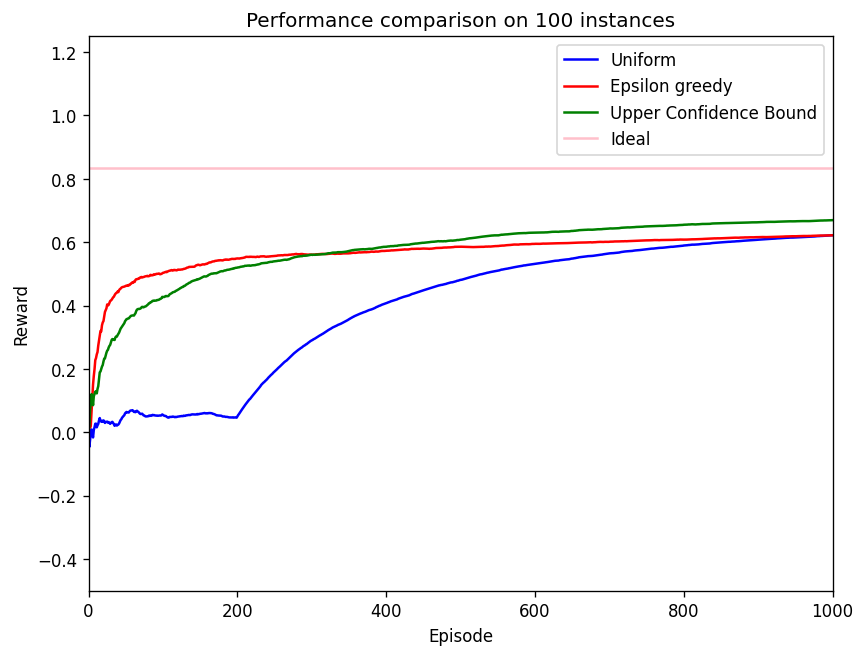

In [99]:
# Plot the results:
fig = plt.figure(figsize=(8, 6), dpi=120)
ax = fig.add_subplot(1, 1, 1)
plt.ylim(-0.5, 1.25)
plt.xlim(0, instance_u.total_plays)

# Plot the ideal scenario when only the best arm is played vs. the actual:
p1 = ax.plot(accumulated_history_of_mean_rewards / instances, 'blue', markersize=1)
p2 = ax.plot(accumulated_history_of_mean_rewards_e / instances, 'red', markersize=1)
p3 = ax.plot(accumulated_history_of_mean_rewards_u / instances, 'green', markersize=1)
p4 = ax.plot(accumulated_history_of_ideal_mean_rewards_e / instances, 'pink', markersize=1)

plt.xlabel('Episode')
plt.ylabel('Reward')
plt.legend(["Uniform", "Epsilon greedy", "Upper Confidence Bound", "Ideal"])

plt.title(f"Performance comparison on {instances} instances")

plt.plot()

# UCB forskellige c værdier

In [100]:
# Config:
instances = 100
arms = 10
episodes = 1000
c1 = 1
np.random.seed(1234)

# Accumulate results across instances data for plotting:
accumulated_history_of_mean_rewards_u1 = np.zeros(episodes)
accumulated_history_of_ideal_mean_rewards_u1 = np.zeros(episodes)
accumulated_explore_count1 = 0

ucb1_bandit = None
times_best_arm_found_u1 = 0

# Create and run instances:
for i in range(0, instances):
  means, variances = kArmedBandit.generate_instance(arms, -1, 1, 1)
  instance_u1 = kArmedBandit(means, variances)
  ucb1_bandit = UpperConfidenceBound(instance_u1, c1)
  ucb1_bandit.run(episodes)

  accumulated_history_of_ideal_mean_rewards_u1 = accumulated_history_of_ideal_mean_rewards_u1 + instance_u1.history_of_ideal_mean_rewards
  accumulated_history_of_mean_rewards_u1 = accumulated_history_of_mean_rewards_u1 + instance_u1.history_of_mean_rewards

  accumulated_explore_count1 = accumulated_explore_count1 + ucb1_bandit.arm_change

  if ucb1_bandit.best_arm == np.argmax(instance_u1.true_means):
    times_best_arm_found_u1 += 1

In [101]:
# Config:
instances = 100
arms = 10
episodes = 1000
c5 = 5
np.random.seed(1234)

# Accumulate results across instances data for plotting:
accumulated_history_of_mean_rewards_u5 = np.zeros(episodes)
accumulated_history_of_ideal_mean_rewards_u5 = np.zeros(episodes)
accumulated_explore_count5 = 0

ucb5_bandit = None
times_best_arm_found_u5 = 0

# Create and run instances:
for i in range(0, instances):
  means, variances = kArmedBandit.generate_instance(arms, -1, 1, 1)
  instance_u5 = kArmedBandit(means, variances)
  ucb5_bandit = UpperConfidenceBound(instance_u5, c5)
  ucb5_bandit.run(episodes)

  accumulated_history_of_ideal_mean_rewards_u5 = accumulated_history_of_ideal_mean_rewards_u5 + instance_u5.history_of_ideal_mean_rewards
  accumulated_history_of_mean_rewards_u5 = accumulated_history_of_mean_rewards_u5 + instance_u5.history_of_mean_rewards

  accumulated_explore_count5 = accumulated_explore_count5 + ucb5_bandit.arm_change

  if ucb5_bandit.best_arm == np.argmax(instance_u5.true_means):
    times_best_arm_found_u5 += 1

In [102]:
# Config:
instances = 100
arms = 10
episodes = 1000
c0 = 0.5
np.random.seed(1234)

# Accumulate results across instances data for plotting:
accumulated_history_of_mean_rewards_u0 = np.zeros(episodes)
accumulated_history_of_ideal_mean_rewards_u0 = np.zeros(episodes)
accumulated_explore_count0 = 0

ucb0_bandit = None
times_best_arm_found_u0 = 0

# Create and run instances:
for i in range(0, instances):
  means, variances = kArmedBandit.generate_instance(arms, -1, 1, 1)
  instance_u0 = kArmedBandit(means, variances)
  ucb0_bandit = UpperConfidenceBound(instance_u0, c0)
  ucb0_bandit.run(episodes)

  accumulated_history_of_ideal_mean_rewards_u0 = accumulated_history_of_ideal_mean_rewards_u0 + instance_u0.history_of_ideal_mean_rewards
  accumulated_history_of_mean_rewards_u0 = accumulated_history_of_mean_rewards_u0 + instance_u0.history_of_mean_rewards

  accumulated_explore_count0 = accumulated_explore_count0 + ucb0_bandit.arm_change

  if ucb0_bandit.best_arm == np.argmax(instance_u0.true_means):
    times_best_arm_found_u0 += 1

[]

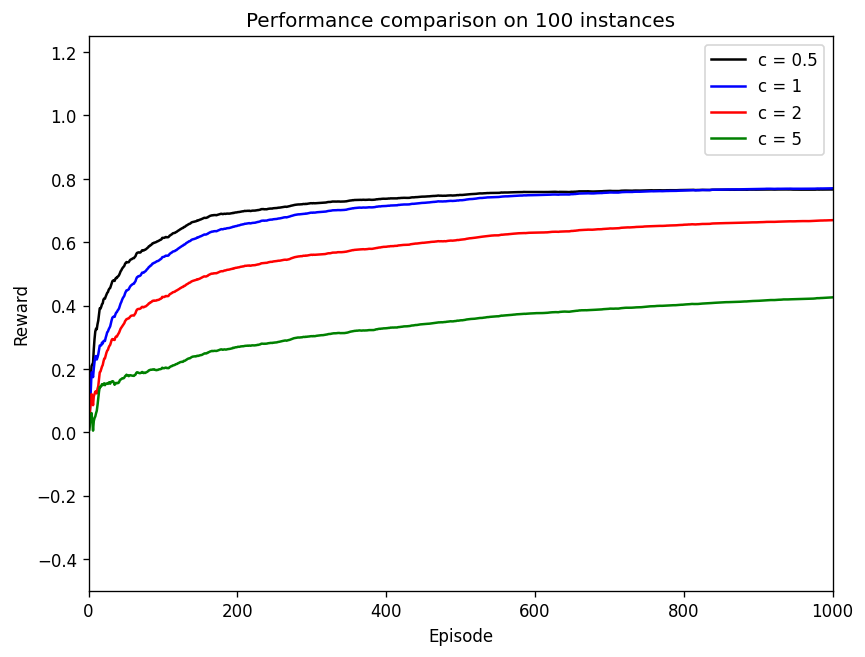

In [103]:
# Plot the results:
fig = plt.figure(figsize=(8, 6), dpi=120)
ax = fig.add_subplot(1, 1, 1)
plt.ylim(-0.5, 1.25)
plt.xlim(0, instance_u.total_plays)

# Plot the ideal scenario when only the best arm is played vs. the actual:
p0 = ax.plot(accumulated_history_of_mean_rewards_u0 / instances, 'black', markersize=1)
p1 = ax.plot(accumulated_history_of_mean_rewards_u1 / instances, 'blue', markersize=1)
p2 = ax.plot(accumulated_history_of_mean_rewards_u / instances, 'red', markersize=1)
p3 = ax.plot(accumulated_history_of_mean_rewards_u5 / instances, 'green', markersize=1)


plt.xlabel('Episode')
plt.ylabel('Reward')
plt.legend(["c = 0.5","c = 1", "c = 2", "c = 5"])

plt.title(f"Performance comparison on {instances} instances")

plt.plot()